In [1]:
from glob import glob
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:

class CorrelationTables:
    def __init__(self):
        print('Please add data primitives in format of data path')
        self.primitives_list = list()
        self.correlation_results = list()
        self.total_result = list()

    def add_research_primitive(self, primitive_path, index_col=0, data_freq='1T'):
        primitive_name = primitive_path.split('/')[-1].split('.')[0]
        primitive_data = pd.read_csv(primitive_path, index_col=index_col)
        primitive_data.index = pd.to_datetime(primitive_data.index)
        print(f'====    Added {primitive_name}  ====')
        self.primitives_list.append({"Primitive_name": primitive_name, "Primitive_content": primitive_data, "Primitive_volume": primitive_data.shape[0],
                                     "Primitive_Frequency": data_freq})
        del primitive_name
        del primitive_data

    def make_correlation_table(self, table_data_slices, show_logs=False):
        print('=' * 10)
        print('Be careful. In one correlation table can be only dataframes with similar shapes')
        #TODO Need to make method to guarantee sync records from datetimes
        # Таким образом находятся пары между которыми можно будет считать корреляцию. Этот способ не очень хороший, но по крайней мере он практически полностью
        # гарантирует отсутствие сдвига во времени в кусках данных
        unique_shapes = np.unique(np.array([primitive["Primitive_volume"] for primitive in self.primitives_list]))
        for similar_shapes in unique_shapes:
            # Собираем список из пар имеющих одинаковые размеры
            buffer_primitives = list(filter(lambda primitive: primitive["Primitive_volume"] == similar_shapes, self.primitives_list))
            # Если не соберется хотя бы 2 переходим к следующему набору примитивов
            if len(buffer_primitives) >= 2:
                res = self._complete_correlation(buffer_primitives, year_of_correlation=table_data_slices, log_show=show_logs)
                self.correlation_results.append(res)
            else:
                print(f"Cannot find a pair (similar shape) to {[primitive['Primitive_name'] for primitive in buffer_primitives]}. Shape={similar_shapes}")
                continue

    def _complete_correlation(self, similar_primitives, year_of_correlation, log_show=True):
        print('=' * 10)
        correlation_dict = {'Primitives_list': [primitive['Primitive_name'] for primitive in similar_primitives], 'Shape': similar_primitives[0]["Primitive_volume"]}
        if log_show:
            print('-' * 5 + '   EXTEND_INFO    ' + '-' * 5)
            print('Primitives total:', len(similar_primitives))
            print('Primitives objects:', [primitive['Primitive_name'] for primitive in similar_primitives])
            print('Primitives shape:', similar_primitives[0]["Primitive_volume"])
            print('-' * 5 + '   END_EXTEND_INFO    ' + '-' * 5)

        results = list()
        # Вырезаем из данных куски на которых будем считать корреляцию. Скорее всего будет корректно работать для разбитий любой ширины
        for borders in year_of_correlation:
            extend_info=False
            if log_show:
                extend_info = True
                print("Current Borders:", borders)
            #   Собирается список из "разбитых" примитивов
            work_primitives = [{"Primitive_name": primitive["Primitive_name"],"Primitive_content": primitive["Primitive_content"].loc[borders[0]: borders[1]], "Primitive_Freq": primitive["Primitive_Frequency"]} for primitive in similar_primitives]
            # Проверяется условие на наличие данных в примитиве
            if work_primitives[0]["Primitive_content"].shape[0] == 0:
                continue
            # Проверка что размер всех "разбитых" примитивов совпадает
            #if np.unique([work_primitive["Primitive_content"].shape[0] for work_primitive in work_primitives]) > 1:
            #    continue

            carretes, corrs =  self._calculate_correlation(work_primitives, extend_info=extend_info, borders=borders)

            results.append({"borders": borders, "timesum": carretes, "corr_tables": corrs})
        correlation_dict['results'] = results
        return correlation_dict


    def _calculate_correlation(self, primitives, borders, list_return_summary=['5T', '30T', '1H', '6H', '1D'],extend_info=True):
        return_correlations = list()
        # Логарифмируем, считаем доходность, ресемплим в зависимости от входной частоты данных
        # Тут можно выбрать с каким столбцом будем работать. Сейчас выбран столбец open
        logged_primitives = [[primitive["Primitive_name"], np.log(primitive["Primitive_content"].open).diff()[1:].resample(primitive["Primitive_Freq"]).first()] for primitive in primitives]
        # Переменная зависящая от количества объектов в "пачке". Нужна для адекватной отрисовки heatmapa
        WIDTH_CONST = 2 * len(primitives)
        fig, ax = plt.subplots(1, len(list_return_summary), figsize=(len(list_return_summary) * WIDTH_CONST ,WIDTH_CONST))
        fig.suptitle(f"{datetime.date.strftime(borders[0], '%Y-%m')}:{datetime.date.strftime(borders[1], '%Y-%m')}")
        # Меняем частоту данных для взятия корреляции за различные временные промежутки
        for number, research_carret in enumerate(list_return_summary):
            if extend_info:
                print('Current Research Resample:', research_carret)

            corr_df = pd.DataFrame()
            # Создаем массив из примитивов преобразованных под временные промежутки
            resampled_primitives = [[primitive[0], primitive[1].resample(research_carret).sum()] for primitive in logged_primitives]
            for obj in resampled_primitives:
                corr_df[f"{obj[0]}"] = obj[1]
            correlation = corr_df.corr()
            # Отрисовка
            sns.heatmap(correlation, ax=ax[number], annot=True, fmt=".2g")
            ax[number].title.set_text(f"{research_carret}")

            return_correlations.append(correlation)
        return list_return_summary, return_correlations

    def unstable_matrix(self):
        # Очень некрасивый метод. Но пока что так
        for buff in self.correlation_results:
            big = pd.DataFrame()
            #print(buff["results"])
            # Проверяем что удалось разбить данные на хотя бы 2 "пачки". Иначе нельзя говорить о стабильности во времени
            if len(buff["results"]) > 1:
                # Очень плохой кусок кода, пока что не понял как его можно поправить чтобы работало
                # DONT TOUCH
                timesum = buff["results"][0]["timesum"]
                _obj = list()
                for i in range(len(timesum)):
                    _return = list()
                    for _b in buff["results"]:
                        _return.append(list(filter(lambda x: x[0] == timesum[i], list(zip(_b["timesum"], _b["corr_tables"])))))
                    _obj.append((timesum[i], _return))
                # DONT TOUCH

                results = list()

                # Связываю все матрицы корреляций за все доступные временные промежутки. Готовый метод не нашел, поэтому написал свое очень некрасивое решение
                # Нужно поправить чтобы пробегаться только по верхнетреугольной матрице.
                for _ in _obj[:]:
                    array_of_df = list()
                    print(_[0])
                    for __ in _[1]:
                        array_of_df.append(__[0][1])

                    #   So dumb... sry
                    i,j = array_of_df[0].shape
                    pdf = pd.DataFrame()
                    for _ in range(i):
                        for __ in range(j):
                            elements = [df.iloc[_,__] for df in array_of_df]
                            # print(array_of_df[0].index[_])
                            # print(f"i={_}, j={__}, std={np.std(elements) / np.mean(elements)}")
                            #   Calculate CV Ratio
                            #   Стандартное отклонение на модуль среднего. Как я понимаю это хоть как-то нормализует показатель
                            pdf.loc[array_of_df[0].index[_], array_of_df[0].index[__]] = np.std(elements) / abs(np.mean(elements))

                    results.append(pdf)
                #   Сверху я считаю показатель для всех частот разбития (пример: 5минут, 10минут, 30минут, 1час) для которых мы считаем корреляцию.
                #   Этот показатель берется из выборки корреляций для разных временных промежутков (пример: 2018-2019;2019-2020;2020-2021).
                #   results.append(pdf) собирает таблицу устойчивости для данных по примеру:
                #   Returns за 10минут для 2019, 2020, 2021 дают корреляции за [P_10min_2019, P_10min_2020, P_10min_2021] по ним и считаем устойчивость на 10минутной частоте returns
                #   Снизу усредняются показатели устойчивости за все частоты разбиения возвратов
                big = pd.concat(results)
                big = pd.pivot_table(big, index=big.index, aggfunc={np.mean})
            self.total_result.append(big)


Please add data primitives in format of data path
====    Added AUDCAD  ====
====    Added EURUSD  ====
====    Added USDCHF  ====
====    Added NQ-21  ====
====    Added EURGBP  ====
====    Added EURCHF  ====
====    Added USDRUB  ====
====    Added USDJPY  ====
====    Added ES-21  ====
====    Added CHFJPY  ====
Be careful. In one correlation table can be only dataframes with similar shapes
Cannot find a pair (similar shape) to ['CHFJPY']. Shape=1078891
Cannot find a pair (similar shape) to ['USDRUB']. Shape=1106191
5T
30T
1H
6H
1D


[Empty DataFrame
 Columns: []
 Index: [],
           AUDCAD    EURCHF    EURGBP    EURUSD    USDCHF    USDJPY
             mean      mean      mean      mean      mean      mean
 AUDCAD  0.000000  0.612686  0.645316  0.216511  0.337272  1.350700
 EURCHF  0.612686  0.000000  0.724673  0.405937  0.324640  0.409411
 EURGBP  0.645316  0.724673  0.000000  0.159863  0.185829  0.940081
 EURUSD  0.216511  0.405937  0.159863  0.000000  0.084669  0.205214
 USDCHF  0.337272  0.324640  0.185829  0.084669  0.000000  0.052682
 USDJPY  1.350700  0.409411  0.940081  0.205214  0.052682  0.000000]

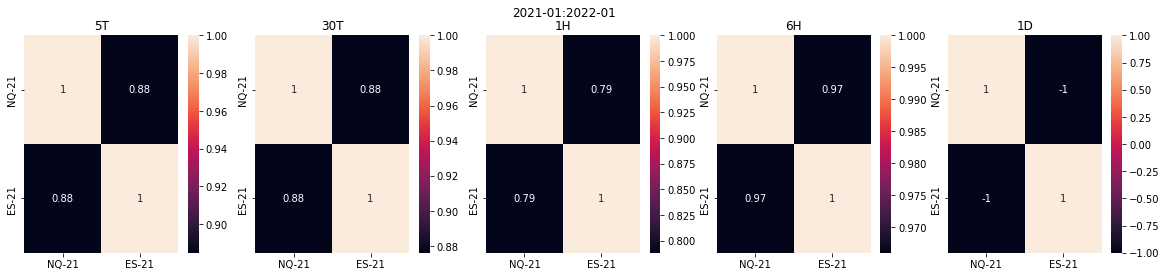

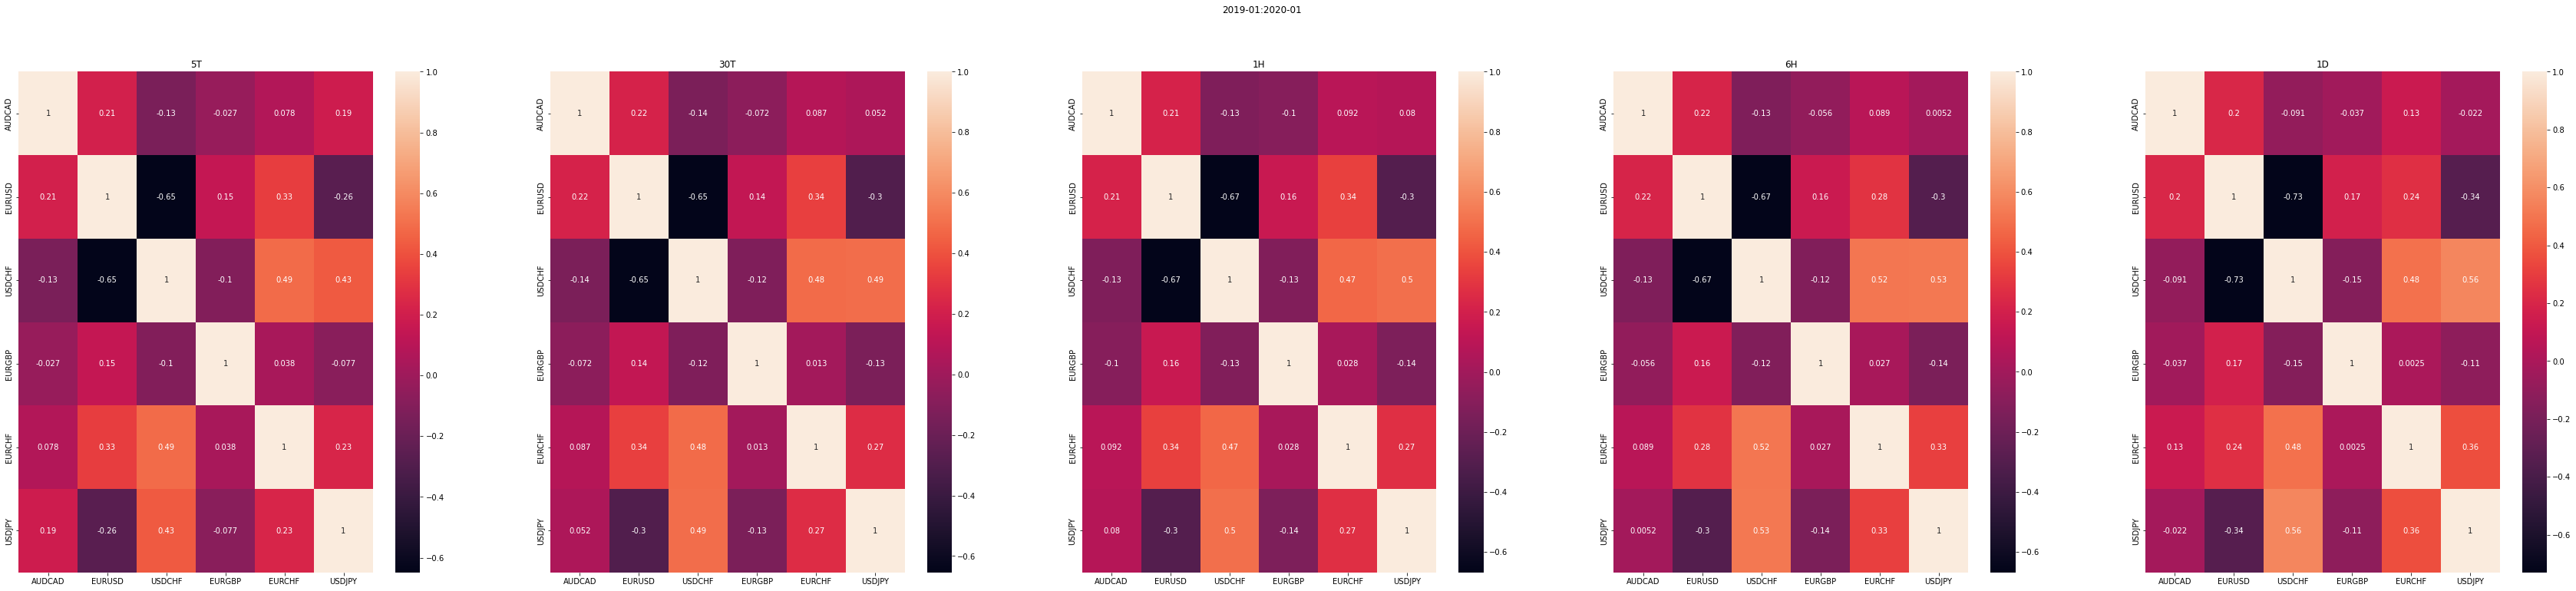

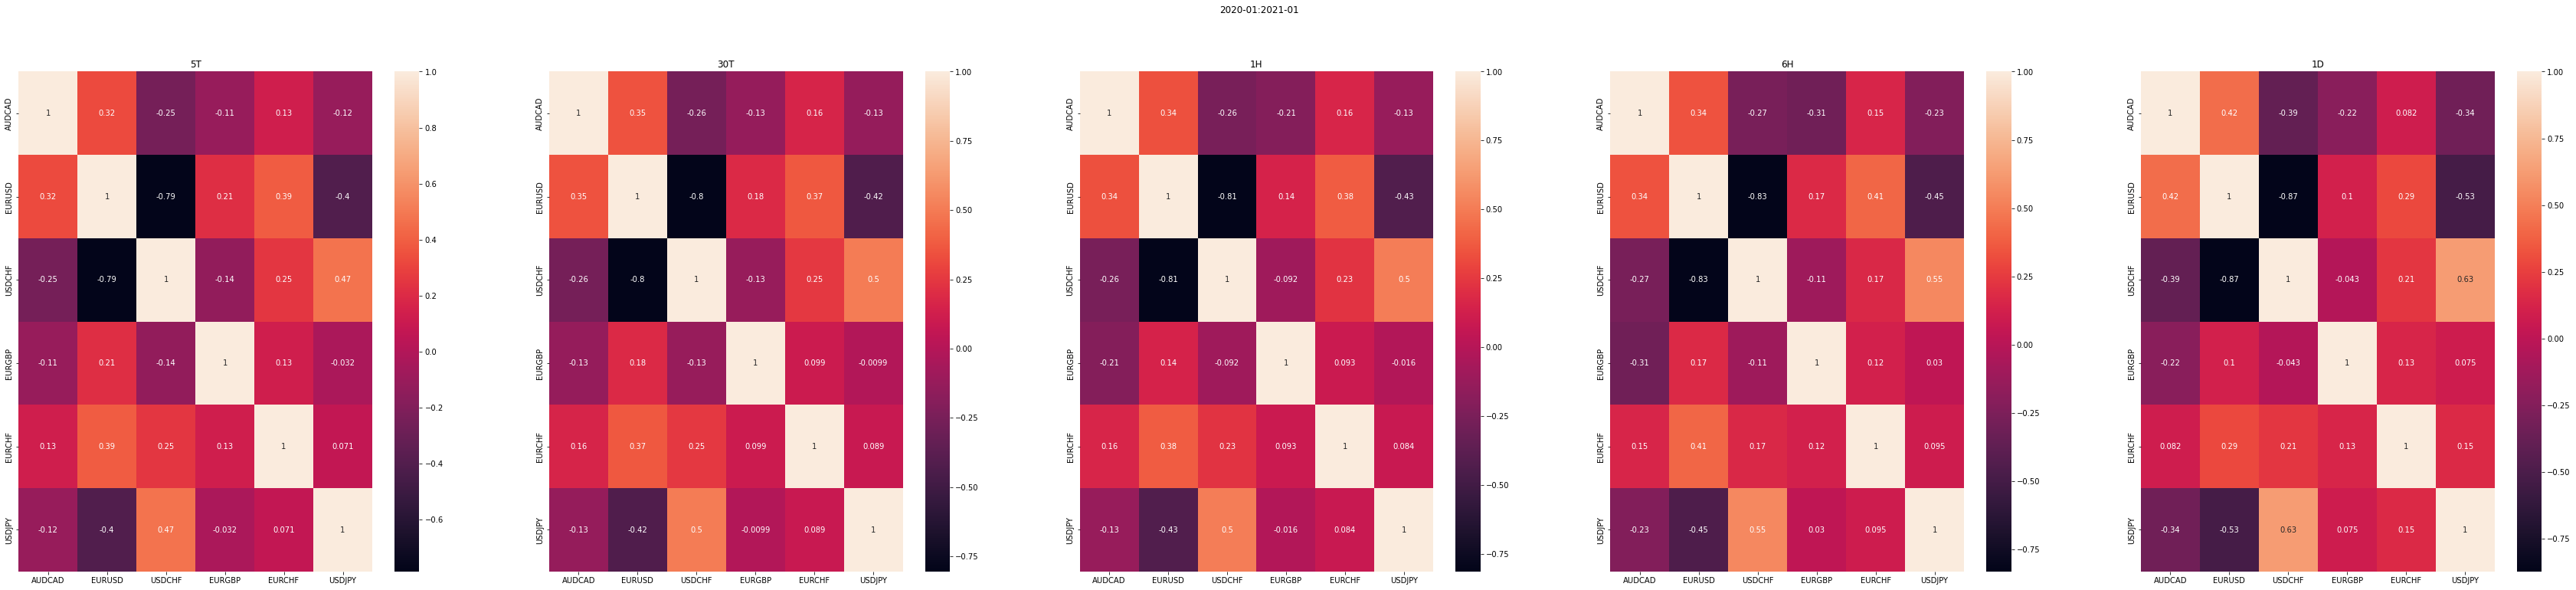

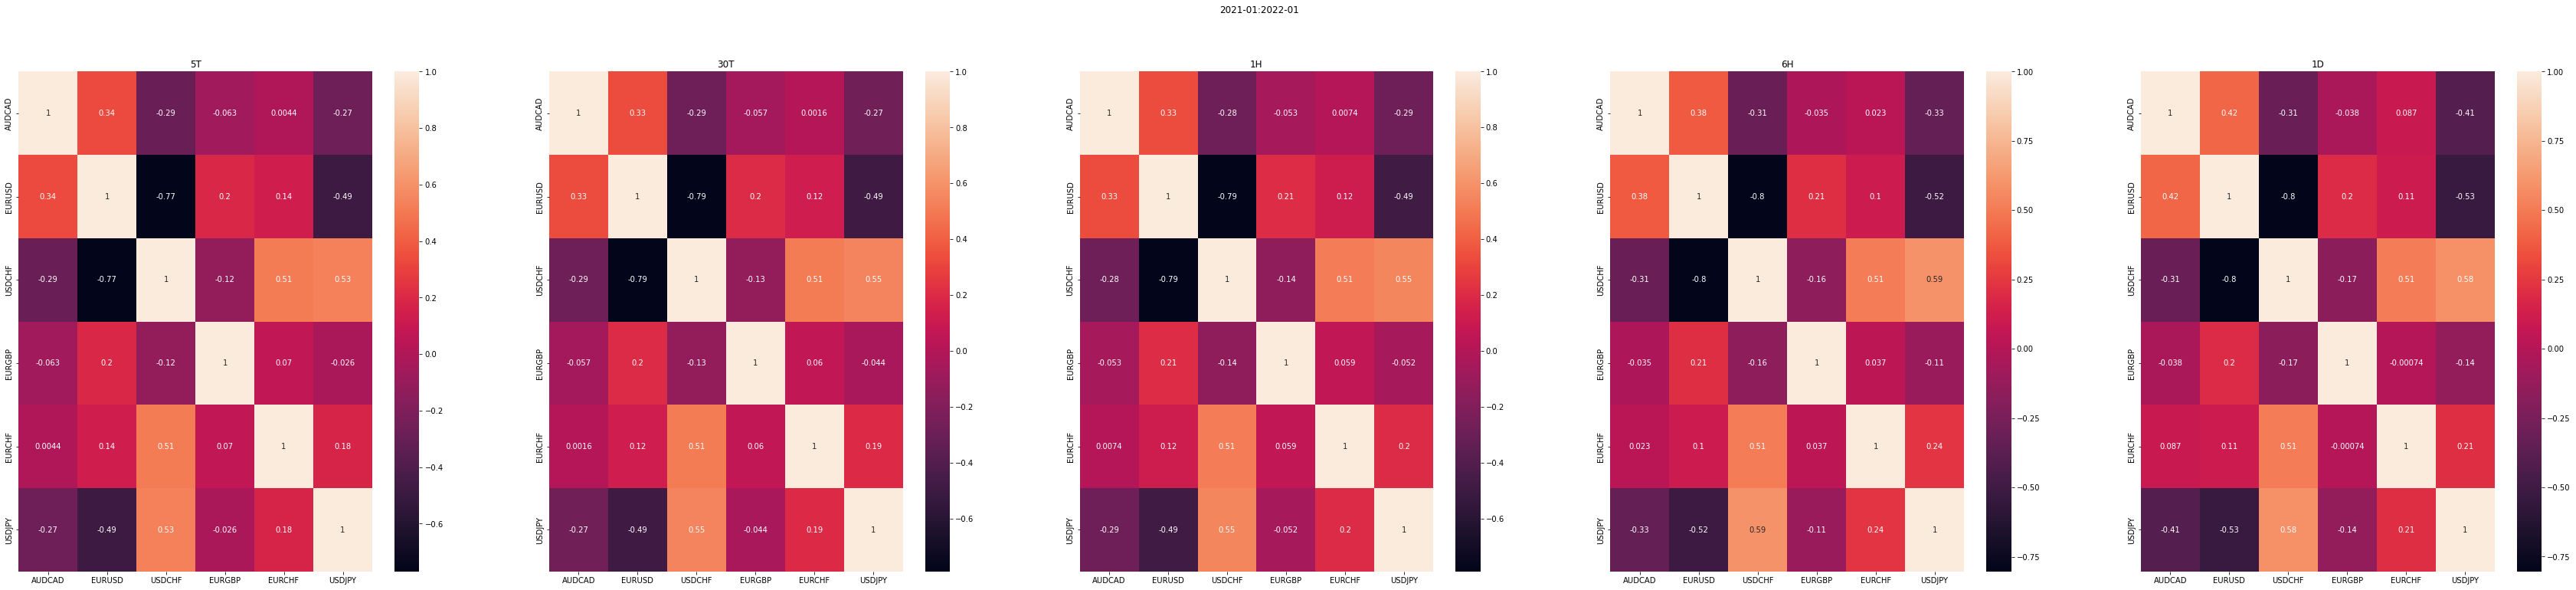

In [138]:
years = [2019, 2020, 2021]
#years = [2019]
borders_list = [[datetime.datetime(year=x, month=1, day=1), datetime.datetime(year=x+1, month=1, day=1)] for x in years]
data_path = glob('zip_data/*.csv')[:10]
TestCorr = CorrelationTables()
for _ in data_path:
    TestCorr.add_research_primitive(_)

TestCorr.make_correlation_table(table_data_slices=borders_list, show_logs=False)
TestCorr.unstable_matrix()
TestCorr.total_result

In [136]:
TestCorr.correlation_results


[{'Primitives_list': ['NQ-21', 'ES-21'], 'Shape': 401, 'results': []},
 {'Primitives_list': ['AUDCAD',
   'EURUSD',
   'USDCHF',
   'EURGBP',
   'EURCHF',
   'USDJPY'],
  'Shape': 1107391,
  'results': []}]

In [68]:
array_of_df[0]

,AUDCAD,EURUSD,USDCHF
AUDCAD,1.000000,0.212305,-0.134066
EURUSD,0.212305,1.000000,-0.648539
USDCHF,-0.134066,-0.648539,1.000000


In [69]:
array_of_df[1]

,AUDCAD,EURUSD,USDCHF
AUDCAD,1.000000,0.324518,-0.251079
EURUSD,0.324518,1.000000,-0.785410
USDCHF,-0.251079,-0.785410,1.000000


In [70]:
array_of_df[2]

,AUDCAD,EURUSD,USDCHF
AUDCAD,1.000000,0.335491,-0.285555
EURUSD,0.335491,1.000000,-0.769185
USDCHF,-0.285555,-0.769185,1.000000


NameError: name 'normalized_dicts' is not defined

In [71]:
np.std([-0.134066, -0.251079, -0.285555])

0.0648327368147365

In [87]:
#   So dumb... sry
i,j = array_of_df[0].shape
pdf = pd.DataFrame()
for _ in range(i):
    for __ in range(j):
        elements = [df.iloc[_,__] for df in array_of_df]
        print(array_of_df[0].index[_])
        print(f"i={_}, j={__}, std={np.std(elements) / np.mean(elements)}")
        pdf.loc[array_of_df[0].index[_], array_of_df[0].index[__]] = np.std(elements)
pdf

AUDCAD
i=0, j=0, std=0.0
AUDCAD
i=0, j=1, std=0.19143747453607063
AUDCAD
i=0, j=2, std=-0.28999238963573853
EURUSD
i=1, j=0, std=0.19143747453607063
EURUSD
i=1, j=1, std=0.0
EURUSD
i=1, j=2, std=-0.0831422101915015
USDCHF
i=2, j=0, std=-0.28999238963573853
USDCHF
i=2, j=1, std=-0.0831422101915015
USDCHF
i=2, j=2, std=0.0


,AUDCAD,EURUSD,USDCHF
AUDCAD,0.000000,0.055665,0.064833
EURUSD,0.055665,0.000000,0.061058
USDCHF,0.064833,0.061058,0.000000
